In [1]:
# modules
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from IndModels.ModelsEdited import NGModel,GAACModel
import numpy as np
from AutoPos.AutoPosModel import AutoPosClass
from sklearn.feature_selection import chi2
from mySVM.model import SVM
from Ensemble.model import Ensemble
import multiprocessing as mp
from sklearn.metrics import precision_score

In [2]:
class TEClassification:
    
    def __init__(self,enzymedata,alignedenzymedata,enzymenamemap,
                ifeaturefilenames,ifeaturelabelfile,random_seed=None):
        
        self.random_seed = random_seed
        
        # original data based on which everything is obtained
        self.df = pd.read_csv(enzymedata,header=None)
        self.enz_names = self.df[0].values
        self.X = self.df.iloc[:,1].values
        self.y = self.df.iloc[:,-1].values
        
        # training and testing data for kmer and gaakmer - will be used for others as well
        self.X_train, self.X_test, self.y_train, self.y_test,self.enz_train,self.enz_test = train_test_split(self.X, self.y,self.enz_names, test_size=0.25, random_state=self.random_seed)
        
        #ng and gaang model
        self.ngmodel = NGModel(self.X_train,self.X_test,self.y_train,self.y_test,random_seed=self.random_seed)
        self.gmodel = GAACModel(self.X_train,self.X_test,self.y_train,self.y_test,random_seed=self.random_seed)

        # aligned data for autopos
        self.df_algn = pd.read_csv(alignedenzymedata,header=None).set_index(0)
        
        # make train test for autopos based on train test for original data
        self.df_algn_train = self.df_algn.loc[self.enz_train]
        self.df_algn_test = self.df_algn.loc[self.enz_test]
        
        self.X_train_algn,self.y_train_algn = self.df_algn_train[1].values,self.df_algn_train[2].values
        self.X_test_algn,self.y_test_algn = self.df_algn_test[1].values,self.df_algn_test[2].values
    
        
        #autopos model
        self.apmodel = AutoPosClass(self.X_train_algn,self.X_test_algn,self.y_train_algn,self.y_test_algn,chi2,None,50,imp=True,verbose=False)
        
        # the ifeature vectors are mapped to the original enzyme names (will change this later)
        # get the alias to original name mappings
        self.df_enmap = pd.read_csv(enzymenamemap,header=None)
        self.enz_mapdict = dict(zip(self.df_enmap[0],self.df_enmap[1]))
        
        self.ifeat_label_file = ifeaturelabelfile
        
        # getting all SVM objects together 
        self.SVMobjects = list(map(self.get_model_ifeat,ifeaturefilenames))
        self.SVMobjects.extend([self.ngmodel.SVMobject,self.gmodel.SVMobject,self.apmodel.SVMobject])
        
        # select only the best models based on training
        self.best_idx,self.best_models = self.select_top_7_models(self.SVMobjects)
        
        # getting all model predictions together
        self.all_model_preds = [svmo.ypredtest for svmo in self.best_models]
        self.en = Ensemble(self.all_model_preds,self.y_test)
        self.precision = precision_score(self.y_test,self.en.preds,labels=[3],average='micro')
        
        pass
    
    
    def get_model_ifeat(self,ifeatfilename):
        df1 = pd.read_csv(ifeatfilename,header=None)
        df2 = pd.read_csv(self.ifeat_label_file,header=None)
        df_feat = df1.merge(df2,on=0).set_index(0)
        enz_name_train = [self.enz_mapdict[al] for al in self.enz_train]
        enz_name_test = [self.enz_mapdict[al] for al in self.enz_test]
        df_feat_train = df_feat.loc[enz_name_train]
        df_feat_test = df_feat.loc[enz_name_test]
        X_train_feat,y_train_feat = df_feat_train.iloc[:,0:-1].values,df_feat_train.iloc[:,-1].values
        X_test_feat,y_test_feat = df_feat_test.iloc[:,0:-1].values,df_feat_test.iloc[:,-1].values
        if X_train_feat.shape[1]<40:
            n_comp = int(0.75*X_train_feat.shape[1])
        else:
            n_comp=40
        svm = SVM(X_train_feat,X_test_feat,y_train_feat,y_test_feat,verbose=False,optimize=False, pca_comp=n_comp,random_seed=self.random_seed)
        return svm
        
    def select_top_7_models(self,SVMOs):
        svm_train_accs = [svmo.acc_train for svmo in SVMOs]
        sorted_idx = np.argsort(svm_train_accs)[::-1]
        best_idx = sorted_idx[:3]
        return best_idx,np.array(SVMOs)[best_idx]
        

In [3]:
%%time
if __name__=='__main__':
    # Sequence and label files for autopos,kmer and gaa-kmer
    datadir = 'Data/TE_ML_Data/'
    enz_file = datadir + 'EnzymeDataset.csv'
    enz_file_aligned = datadir + 'EnzymeDatasetAligned.csv'

    # Feature files for iFeature 
    ifeatdatadir = 'Data/FeatureVectors/iFeatureVectors/'
    ifeature_files = [ifeatdatadir+f.name for f in os.scandir(ifeatdatadir)]
    ifeatlabelfile = 'Data/Labels/'+'Labels_Classification.csv'

    # alias to original enzyme name
    enz_name_map = datadir + 'EnzymeNameMap.csv'
    te = TEClassification(enz_file,enz_file_aligned,enz_name_map,
                          ifeature_files,ifeatlabelfile,random_seed=7)
    
    def multi_func(rs):
        te_i = TEClassification(enz_file,enz_file_aligned,enz_name_map,
                          ifeature_files,ifeatlabelfile,random_seed=rs)
        return te_i.precision,te_i.en.acc    
    
    pool = mp.Pool(mp.cpu_count())

    
    
    
    metrics = list(pool.map(multi_func,range(10000)))
    


CPU times: user 2.61 s, sys: 365 ms, total: 2.97 s
Wall time: 14min 9s


In [4]:
prec = [metr[0] for metr in metrics]
accs = [metr[1] for metr in metrics]

In [5]:
print(min(prec),np.mean(prec),max(prec),np.std(prec))

0.38461538461538464 0.8433256104197959 1.0 0.10225805510715066


In [6]:
print(min(accs),np.mean(accs),max(accs),np.std(accs))

0.4482758620689655 0.7639206896551725 0.9655172413793104 0.0721116546559403


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   9.,   28.,   42.,  204.,  446., 1278., 1641., 2493., 2519.,
        1340.]),
 array([0.38461538, 0.44615385, 0.50769231, 0.56923077, 0.63076923,
        0.69230769, 0.75384615, 0.81538462, 0.87692308, 0.93846154,
        1.        ]),
 <BarContainer object of 10 artists>)

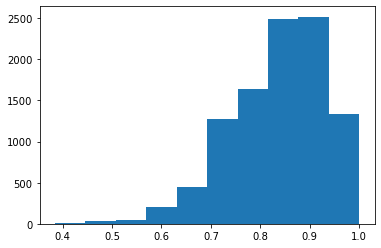

In [10]:
plt.hist(prec)

(array([   6.,   13.,  156.,  288., 1594., 3463., 1820., 2189.,  350.,
         121.]),
 array([0.44827586, 0.5       , 0.55172414, 0.60344828, 0.65517241,
        0.70689655, 0.75862069, 0.81034483, 0.86206897, 0.9137931 ,
        0.96551724]),
 <BarContainer object of 10 artists>)

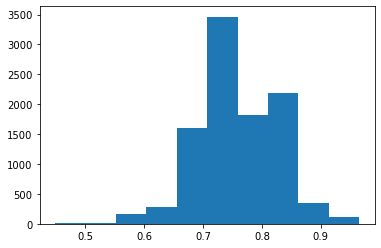

In [12]:
plt.hist(accs)